In [1]:
from __future__ import print_function
from __future__ import division
from future import standard_library
import sys
import os
import wget
import re
from ufal.udpipe import Model, Pipeline

In [2]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.13.1


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [30]:
from utils.preprocessing import *
from utils.triplet_loss import *
from utils.model import *

### Подгружаем библиотке для разметки по частям речи при помощи UDPipe

In [5]:
standard_library.install_aliases()

# URL of the UDPipe model
udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
udpipe_filename = udpipe_model_url.split('/')[-1]

if not os.path.isfile(udpipe_filename):
    print('UDPipe model not found. Downloading...')
    wget.download(udpipe_model_url)

print('\nLoading the model...')
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

print('\nModel loaded successfully')


Loading the model...

Model loaded successfully


In [6]:
data = pd.read_pickle('data/banki_ru/sberbank/replies.pkl')
data.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
276,ShkolinaElena,sberbank,None,1,0,оценка: 1 проверяется,Снимал деньги в банкомате 20.03.2017 в...,07.04.2017 0:36,Не исправно работающие банкоматы проблема банка,1
280,yanamalkova94,sberbank,None,1,0,оценка: 1 проверяется,06.04.2017г. в 22:55 (дата указана на чеке) мн...,06.04.2017 23:12,"Банкомат забрал деньги и выдал ""аварийный чек""",1
281,Nataliivanova,sberbank,None,1,0,оценка: 1 проверяется,Я являюсь поручителем по просроченному кредиту...,06.04.2017 22:01,Политика только Калужского отделения банка?,1
282,nastenka.eroha,sberbank,None,1,0,оценка: 1 проверяется,6 апреля 2017года обратилась в отделение №5221...,06.04.2017 21:47,Некомпетентность сотрудников!,1
287,sparkimus,sberbank,None,1,0,оценка: 3 проверяется,Добрый день!Меня зовут Ольга Александровна(Шве...,06.04.2017 21:42,Сколько можно ждать???!!!,3


In [7]:
txt = [title for title in data['title']]
del data

txt[:5]

['Не исправно работающие банкоматы проблема банка',
 'Банкомат забрал деньги и выдал "аварийный чек"',
 'Политика только Калужского отделения банка?',
 'Некомпетентность сотрудников!',
 'Сколько можно ждать???!!!']

### Подгружаем предобученную w2v модель, производим лемматизация и векторизацию

In [8]:
import io
import zipfile
import pathlib
import urllib.request

WORD2VEC_PATH = pathlib.Path('w2v_model/model.bin')

if not WORD2VEC_PATH.exists():
    print('Downloading model...')
    model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
    m = wget.download(model_url)
    model_file = model_url.split('/')[-1]
    with zipfile.ZipFile(model_file, 'r') as archive:
        archive.extract('model.bin')
        WORD2VEC_PATH = pathlib.Path('model.bin')

In [9]:
# !pip install paramiko
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

In [10]:
def text_to_vec(text):
    vector = []
    tmp = process(process_pipeline, text=text)
    for i in tmp:
        if i in word2vec:
            vector.append(word2vec[i])
    return np.mean(vector, axis=0, dtype=np.float32)

In [11]:
txt_w2v = []
for i in tqdm(txt):
    emb = text_to_vec(i).tolist()
    if(type(emb) == list):
        txt_w2v.append(emb)
del txt

  0%|          | 0/50044 [00:00<?, ?it/s]/home/pavel/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pavel/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 50044/50044 [03:38<00:00, 229.24it/s]


In [12]:
news = pd.read_csv('data/news.csv')
news.head()

,title,url,text
0,Центробанк сообщил о сбое в системе быстрых пл...,https://lenta.ru/news/2019/04/07/sboy/,В системе быстрых платежей обнаружены техничес...
1,Названы победители Национальной премии бизнес-...,https://lenta.ru/news/2019/04/05/premia/,Лучшие российские специалисты в третий раз ста...
2,России предсказали замедление роста ВВП,https://lenta.ru/news/2019/04/05/gdpdown/,Всемирный банк понизил для России прогноз по р...
3,«Магнит» поборется с российским олигархом за «...,https://lenta.ru/news/2019/04/05/mangit_lenta/,Розничная сеть «Магнит» направила в марте друг...
4,Российские богачи отказались доверить банкам с...,https://lenta.ru/news/2019/04/05/cash_milliona...,В России насчитывается более 163 тысяч миллион...


In [13]:
titles_w2v = []
for title in tqdm(news.loc[:, 'title']):
    emb = text_to_vec(title).tolist()
    if(type(emb) == list):
        titles_w2v.append(emb)
del news

100%|██████████| 10000/10000 [01:10<00:00, 141.17it/s]


### Обучаем модели из sklearn по поиску анамалий

In [14]:
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import time

warnings.filterwarnings('ignore')

In [15]:
def fitting_algorithms(data):
    anomaly_algorithms = [('Robust covariance', EllipticEnvelope()),
                          ('One-Class SVM', OneClassSVM()),
                          ('Isolation Forest', IsolationForest()),
                          ('Local Outlier Factor', LocalOutlierFactor())]



    for name, algorithm in anomaly_algorithms:
        if name != 'Local Outlier Factor':
            start = time.time()
            algorithm.fit(data)

            print('fitting ' + name + ': ' + '{:.2f}'.format(time.time() - start) + 's')
    
    return anomaly_algorithms

In [16]:
algorithm_name, algorithm = 'Isolation Forest', IsolationForest()
algorithm.fit(txt_w2v)

IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

### Понижаем размерность для визуализации

In [17]:
# понижаем размерность до 2d
pca_2d = PCA(n_components=2)
pca_2d.fit(txt_w2v + titles_w2v)
txt_dcmp_2d = pca_2d.transform(txt_w2v)
titles_dcmp_2d = pca_2d.transform(titles_w2v)

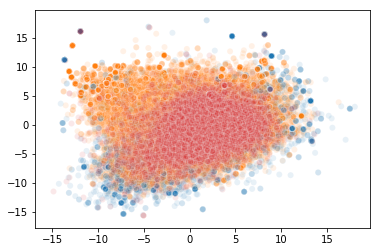

In [19]:
pred = algorithm.predict(txt_w2v)

plt.scatter(txt_dcmp_2d[:, 0], txt_dcmp_2d[:, 1],
            color=['tab:orange' if l == 1 else 'tab:blue' for l in pred],
            edgecolors='w', alpha=0.1)

plt.scatter(titles_dcmp_2d[:, 0], titles_dcmp_2d[:, 1],
                  color='tab:red', edgecolors='w', alpha=0.1)

plt.show()

### Посчитаем качество

In [20]:
X, Y = [], []
for i in txt_w2v:
    X.append(i)
    Y.append(1)
    
for i in titles_w2v:
    X.append(i)
    Y.append(0)

x_train_variable, x_test_variable, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

In [21]:
pred = algorithm.predict(x_test_variable)
y_pred = [1 if i == 1 else 0 for i in pred]

print(algorithm_name + ' | F1 score: {:.5f}'.format(f1_score(y_test, y_pred)))

Isolation Forest | F1 score: 0.86484


### Полученный результат говорит о том, что алгоритм Isolation Forest хорошо кластеризовал заголовки с банки.ру. Теперь попробуем сильнее разнести вектора заголовков в пространстве. Это должно увеличить точность предсказаний. Для этого обучим небольшую нейросеть с триплет лосом.

## Попробуем разнести в пространстве наши вектора, для этого обучим нейросеть с триплет лосом.

In [22]:
# Добавим в аномалии текст не связанный с банковской тематикой. Например, Маяковского. (⊙_⊙)
file = open(file='data/Mayakovsky.txt', mode='r', encoding='latin1')
anom = [paragraph.encode('latin1').decode('cp1251') for paragraph in file]
file.close()

for line in anom[13:18]:
    print(line)

Вашу мысль,

мечтающую на размягченном мозгу,

как выжиревший лакей на засаленной кушетке,

буду дразнить об окровавленный сердца лоскут:

досыта изъиздеваюсь, нахальный и едкий.



In [23]:
anom_w2v = []
for i in tqdm(anom):
    emb = text_to_vec(i).tolist()
    if(type(emb) == list):
        anom_w2v.append(emb)
del anom

100%|██████████| 61104/61104 [01:30<00:00, 676.28it/s] 


### Подготовка данных и обучение модели с триплет лосом, для лучшей кластеризации заголовков с банки.ру

In [24]:
X, Y = [], []
for i in txt_w2v:
    X.append(i)
    Y.append(1)
    
for i in titles_w2v + anom_w2v:
    X.append(i)
    Y.append(0)

In [25]:
x_train_variable, x_test_variable, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

In [26]:
def parser(x, y):
    features = {"x": x}
    return features, y

def parser_p(x):
    features = {"x": x}
    return features

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train_variable, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test_variable, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def pred_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_p))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser_p)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [31]:
config = tf.estimator.RunConfig(tf_random_seed=123,
                                save_checkpoints_steps=500,
                                model_dir='custom',
                                save_summary_steps=20)
classifier = tf.estimator.Estimator(model_fn=model_custom,
                                         config=config)

tf.estimator.train_and_evaluate(
    classifier,
    train_spec=tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps = 12000),
    eval_spec=tf.estimator.EvalSpec(input_fn= eval_input_fn, steps = None, start_delay_secs=0, throttle_secs=60)
)

INFO:tensorflow:Using config: {'_model_dir': 'custom', '_tf_random_seed': 123, '_save_summary_steps': 20, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb82b911400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will h

NameError: name 'tf' is not defined

### Проганяем данные через обученную модель

In [ ]:
X_p = txt_w2v
txt_em, txt_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    txt_em.append(next(prediction))

for i in range(len(X_p)):
    txt_em_norm.append(txt_em[i]['embeddings'])

In [ ]:
X_p = titles_w2v
titles_em, titles_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    titles_em.append(next(prediction))

for i in range(len(X_p)):
    titles_em_norm.append(titles_em[i]['embeddings'])

In [ ]:
X_p = anom_w2v
anom_em, anom_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    anom_em.append(next(prediction))

for i in range(len(X_p)):
    anom_em_norm.append(anom_em[i]['embeddings'])

### Обучаем модели из sklearn по поиску анамалий на векторах, которые мы получили

In [ ]:
anomaly_algorithms = fitting_algorithms(txt_em_norm)

### Понижаем размерность для визуализации

In [ ]:
# понижаем размерность до 2d
pca_2d = PCA(n_components=2)
pca_2d.fit(txt_em_norm + titles_em_norm + anom_em_norm)
txt_dcmp_2d = pca_2d.transform(txt_em_norm)
titles_dcmp_2d = pca_2d.transform(titles_em_norm)
anom_dcmp_2d = pca_2d.transform(anom_em_norm)

# понижаем размерность до 3d
pca_3d = PCA(n_components=3)
pca_3d.fit(txt_em_norm + titles_em_norm + anom_em_norm)
txt_dcmp_3d = pca_3d.transform(txt_em_norm)
titles_dcmp_3d = pca_3d.transform(titles_em_norm)
anom_dcmp_3d = pca_3d.transform(anom_em_norm)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

n, i, j = 0, 0, 0
for name, algorithm in anomaly_algorithms:
    axs[i, j].set(title=name)
    print(name + ' preparing...')
    
    if name != "Local Outlier Factor":
        pred = algorithm.predict(txt_em_norm)
    else:
        pred = algorithm.fit_predict(txt_em_norm)
        
    axs[i, j].scatter(txt_dcmp_2d[:, 0], txt_dcmp_2d[:, 1],
                      color=['tab:orange' if l == 1 else 'tab:blue' for l in pred],
                      alpha=0.1)
    
    axs[i, j].scatter(titles_dcmp_2d[:, 0], titles_dcmp_2d[:, 1],
                      color='tab:red', alpha=0.1)
    
    n += 1
    i, j = n // 2, n % 2

plt.show()

In [ ]:
X_p = x_test_variable
test_em, test_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    test_em.append(next(prediction))

for i in range(len(X_p)):
    test_em_norm.append(test_em[i]['embeddings'])

for name, algorithm in anomaly_algorithms:
    if name != "Local Outlier Factor":
        pred = algorithm.predict(test_em_norm)
        y_pred = [1 if i == 1 else 0 for i in pred]

        print(name + ' | F1 score: {:.5f}'.format(f1_score(y_test, y_pred)))